In [1]:
# This is only valid when the package is not installed
import sys
sys.path.append('../../') # two folders up

In [2]:
import DeepINN as dp

Using default backend: PyTorch
Using Pytorch:  2.0.1+cu117


In [3]:
from torch import nn
import torch

# Test 1

In [4]:
x = torch.tensor([2.0], requires_grad = True)
print("x:", x)

y = x**2 + 1
print("y:", y)

x: tensor([2.], requires_grad=True)
y: tensor([5.], grad_fn=<AddBackward0>)


$$y=x^2 +1\\
\frac{dy}{dx} = 2x$$

In [5]:
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, x, retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([4.])


In [6]:
jacobian = dp.constraint.Jacobian(x, y)
# jacobian_matrix = jacobian(0, 1)
jacobian

# A note for the future.
If we need to use the same graph to computer more gradients then we need to use retain_graph=True
We need to investigate whether we need this.

In [7]:
jacobian(0,0)


tensor([4.])

here we confirmed that both compute the same gradient. 

# 1D tensor with multiple values.

In [8]:
# Define a simple neural network for demonstration
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear = nn.Linear(2, 1) # automatic weights initialisation

    def forward(self, x):
        return self.linear(x)

In [9]:
# Create random input tensor
X = torch.tensor([1.0, 2.0], requires_grad=True)
X, X.size()

(tensor([1., 2.], requires_grad=True), torch.Size([2]))

In [10]:
# Instantiate the neural network
net = Net()

# Forward pass
y = net(X)
y

tensor([-0.7828], grad_fn=<AddBackward0>)

In [11]:
# pytorch gradient
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, X, retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([ 0.1618, -0.5502])


In [12]:
jacobian = dp.constraint.Jacobian(X, y)

In [13]:
# Compute the Jacobian matrix
jacobian_matrix = jacobian(0, 0)  # Compute dy_0/dX_1

In [14]:
jacobian_matrix

tensor([ 0.1618, -0.5502])

Again we verified that dp and torch are giving the same results.

Let us do a manual forward prop for fun.

In [15]:
# Manually compute gradient
weights = net.linear.weight
biases = net.linear.bias

In [16]:
output = torch.matmul(X, weights.t()) + biases
y, output # notice both are same. ok I am stupid

(tensor([-0.7828], grad_fn=<AddBackward0>),
 tensor([-0.7828], grad_fn=<AddBackward0>))

# 2D tensor

In [17]:
# Create a 2D input tensor
X = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)
print("X:\n", X)

X:
 tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [18]:
# Define a function that operates on the input tensor
def func(x):
    return torch.sin(x)

In [19]:
# Compute the output tensor
y = func(X)
print("y:\n", y)

y:
 tensor([[ 0.8415,  0.9093],
        [ 0.1411, -0.7568]], grad_fn=<SinBackward0>)


In [20]:
# pytorch gradient
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, X, grad_outputs=torch.ones_like(y), retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([[ 0.5403, -0.4161],
        [-0.9900, -0.6536]])


In [21]:
# Instantiate the Jacobian module
jacobian = dp.constraint.Jacobian(X, y)

says the first column denotes x-coodinates and the the second column denotes the y-coordintes.

In [22]:
# dy/dx-coordinates, dy/dy-coordinates 
jacobian(0, 0), jacobian(0, 1)

(tensor([[ 0.5403],
         [-0.9900]], grad_fn=<IndexBackward0>),
 tensor([[-0.4161],
         [-0.6536]], grad_fn=<IndexBackward0>))

# Gradients with actual geometry

In [23]:
# Let us make a simple rectangle
X = dp.spaces.R2('x') #  2D space stencil
R = dp.domains.Parallelogram(X, [0,0], [1,0], [0,1])

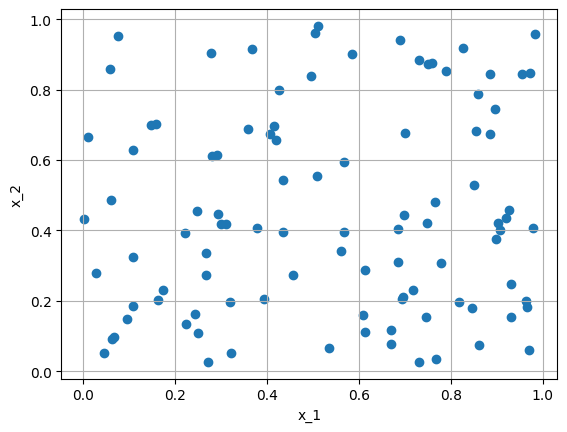

In [24]:
collocation_points = dp.samplers.RandomUniformSampler(R, n_points = 100)
dp.utils.scatter(X, collocation_points)

In [25]:
# sample collcocation points
collocation_points = dp.constraint.PDE(geom = R,
                                       sampling_strategy= "random",
                                       no_points = 100)

In [26]:
collocation_points_sampled = collocation_points.sampler_object().sample_points().as_tensor
collocation_points_sampled.size()

torch.Size([100, 2])

In [27]:
collocation_points_labels = collocation_points.sample_labels(collocation_points_sampled).unsqueeze(1)
collocation_points_labels.size()

torch.Size([100, 1])

In [28]:
import matplotlib.pyplot as plt

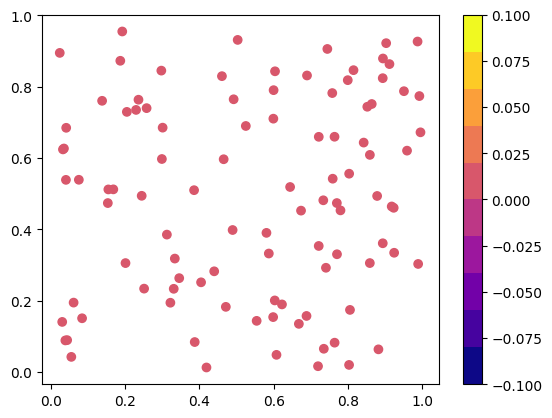

In [29]:
# The variation in BCs based on the provided function : lambda X: X[:,0]**2
plt.scatter(collocation_points_sampled[:,0], collocation_points_sampled[:,1], c = collocation_points_labels, cmap=plt.get_cmap('plasma',10))
plt.colorbar()

In [30]:
collocation_points_sampled.requires_grad = True # enable chain rule

# to differentiate a function, we need an actual function/neural network which take the collocation_points_sampled as the input and outputs the y
y = (collocation_points_sampled[:,0] ** 2).unsqueeze(1) + collocation_points_labels
y.size()

torch.Size([100, 1])

In [31]:
# pytorch gradient
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, collocation_points_sampled, grad_outputs=torch.ones_like(y), retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([[1.2057, 0.0000],
        [1.2070, 0.0000],
        [1.8460, 0.0000],
        [1.8055, 0.0000],
        [1.9013, 0.0000],
        [0.6616, 0.0000],
        [0.4717, 0.0000],
        [0.4091, 0.0000],
        [1.6107, 0.0000],
        [0.9305, 0.0000],
        [0.5020, 0.0000],
        [1.1981, 0.0000],
        [0.7711, 0.0000],
        [0.9842, 0.0000],
        [1.7872, 0.0000],
        [1.5279, 0.0000],
        [1.3354, 0.0000],
        [1.1736, 0.0000],
        [1.5407, 0.0000],
        [1.8232, 0.0000],
        [1.4812, 0.0000],
        [1.5153, 0.0000],
        [1.7039, 0.0000],
        [1.5274, 0.0000],
        [0.0825, 0.0000],
        [0.0703, 0.0000],
        [1.4697, 0.0000],
        [1.5987, 0.0000],
        [0.1506, 0.0000],
        [1.7178, 0.0000],
        [1.4424, 0.0000],
        [0.5948, 0.0000],
        [0.9421, 0.0000],
        [0.1680, 0.0000],
        [1.9178, 0.0000],
        [0.6019, 0.0000],
        [1.6844, 0.0000],
        [1.2149, 0.0

In [32]:
# Instantiate the Jacobian module
jacobian = dp.constraint.Jacobian(collocation_points_sampled, y)

In [33]:
# dy/dx-coordinates, 
jacobian(i = 0, j = 0)

tensor([[1.2057],
        [1.2070],
        [1.8460],
        [1.8055],
        [1.9013],
        [0.6616],
        [0.4717],
        [0.4091],
        [1.6107],
        [0.9305],
        [0.5020],
        [1.1981],
        [0.7711],
        [0.9842],
        [1.7872],
        [1.5279],
        [1.3354],
        [1.1736],
        [1.5407],
        [1.8232],
        [1.4812],
        [1.5153],
        [1.7039],
        [1.5274],
        [0.0825],
        [0.0703],
        [1.4697],
        [1.5987],
        [0.1506],
        [1.7178],
        [1.4424],
        [0.5948],
        [0.9421],
        [0.1680],
        [1.9178],
        [0.6019],
        [1.6844],
        [1.2149],
        [0.4890],
        [0.5155],
        [1.4386],
        [0.8088],
        [0.0478],
        [0.5978],
        [0.0877],
        [1.3471],
        [0.1224],
        [1.7176],
        [0.3844],
        [0.2759],
        [1.3766],
        [1.6062],
        [1.9843],
        [1.2882],
        [1.3792],
        [1

In [34]:
#dy/dy-coordinates 
jacobian(i = 0, j = 1)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      